**Machine learning Assingment 2 group 89**

s4046373

## Step 1: EDA

Combined data shape: (9896, 7)
cellType
2    4079
1    2543
0    1888
3    1386
Name: count, dtype: int64
isCancerous
0    5817
1    4079
Name: count, dtype: int64


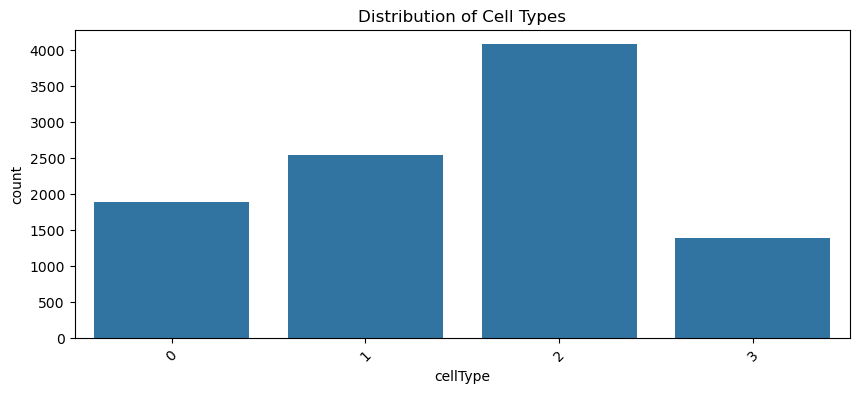

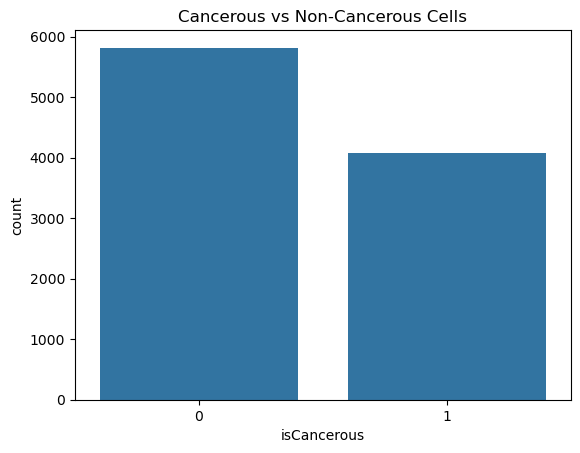

In [68]:
# Step 1: Load and Explore Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split

# Load metadata CSV files for both main and extra labelled datasets
main_labels = pd.read_csv('./data_labels_mainData.csv')
extra_labels = pd.read_csv('./data_labels_extraData.csv')

# Tag the source for clarity during processing
main_labels['source'] = 'main'
extra_labels['source'] = 'extra'

# Combine both datasets
# Only the main dataset has labels for both tasks
data = pd.concat([main_labels], ignore_index=True)

# Basic data overview
print("Combined data shape:", data.shape)
print(data['cellType'].value_counts())
print(data['isCancerous'].value_counts())

# Plot class distributions to identify imbalance
plt.figure(figsize=(10,4))
sns.countplot(x='cellType', data=data)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

sns.countplot(x='isCancerous', data=data)
plt.title('Cancerous vs Non-Cancerous Cells')
plt.show()

## Step 2: Visualise

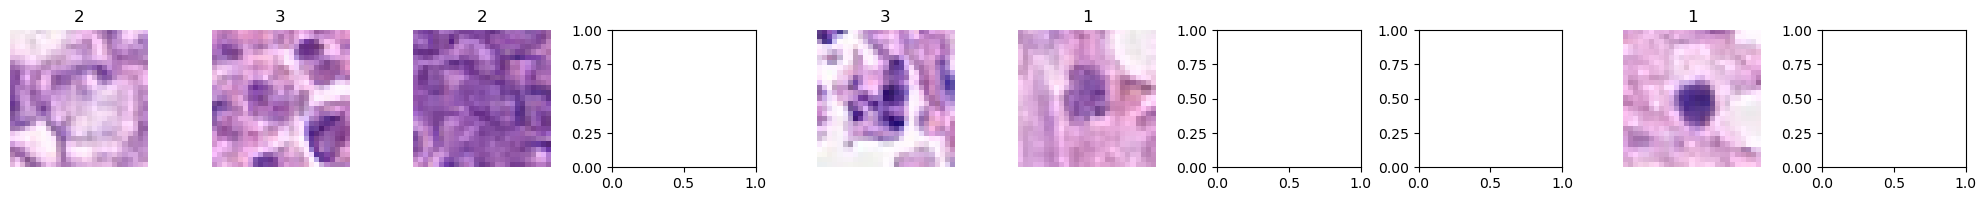

In [70]:
# Step 2: Visualize some images
# Randomly sample and display 10 image examples with their cell type label
import random
from PIL import Image

sample = data[data['source'] == 'main'].sample(10)
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, row in sample.iterrows():
    img = Image.open(f"./patch_images/{row['ImageName']}")
    axs[i % 10].imshow(img)
    axs[i % 10].axis('off')
    axs[i % 10].set_title(row['cellType'])
plt.tight_layout()
plt.show()

## Step 3: Data preprocessing and Data splitting

In [74]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Clean and standardize labels
data['isCancerous'] = data['isCancerous'].astype(str).str.strip()
data['cellType'] = data['cellType'].astype(str).str.strip()

# Encode categorical labels into integers
cell_encoder = LabelEncoder()
cancer_encoder = LabelEncoder()
data['cell_type_enc'] = cell_encoder.fit_transform(data['cellType'])
data['isCancerous_enc'] = cancer_encoder.fit_transform(data['isCancerous'])

# One-hot encode
data['cell_onehot'] = list(to_categorical(data['cell_type_enc']))
data['cancer_onehot'] = list(to_categorical(data['isCancerous_enc']))

# Drop rows where one-hot failed
data = data[data['cancer_onehot'].apply(lambda x: len(x) == 2)]

# Only use main dataset (with full labels) for training/testing
main_data = data[data['source'] == 'main']

# Create train/val/test splits (60/20/20)
train_data, test_data = train_test_split(main_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train:", len(train_data), "Val:", len(val_data), "Test:", len(test_data))

Train: 5937 Val: 1979 Test: 1980


## Step 4: Data Generators for Keras

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Custom Keras data generator for cancer/cell-type tasks using patch_images folder
class CustomDataGenerator(Sequence):
    def __init__(self, df, task='cancer', batch_size=32, dim=(27,27), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.task = task  # 'cancer' or 'cell'
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[indexes]
        X = np.empty((self.batch_size, *self.dim, 3))  # RGB images

        if self.task == 'cancer':
            y = np.empty((self.batch_size, 2))
        else:
            y = np.empty((self.batch_size, len(self.df.iloc[0]['cell_onehot'])))

        for i, row in enumerate(batch_df.itertuples()):
            img = img_to_array(load_img(f"./patch_images/{row.ImageName}", target_size=self.dim)) / 255.0
            X[i] = img
            y[i] = row.cancer_onehot if self.task == 'cancer' else row.cell_onehot

        return X, y

# Instantiate generators for cancer classification
train_gen_cancer = CustomDataGenerator(train_data, task='cancer')
val_gen_cancer = CustomDataGenerator(val_data, task='cancer')

## Step 5: CNN Model for Cancerous classification

In [80]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Create a simple CNN model for binary classification (cancerous vs. not)
model_cancer = Sequential([
    Input(shape=(27,27,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_cancer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cancer.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,986 (476.51 KB)

 Trainable params: 121,986 (476.51 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Training and saving the model and visualising training

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
185/185 - 4s - 22ms/step - accuracy: 0.7571 - loss: 0.4825 - val_accuracy: 0.7976 - val_loss: 0.4228
Epoch 2/15
185/185 - 2s - 12ms/step - accuracy: 0.8573 - loss: 0.3361 - val_accuracy: 0.8463 - val_loss: 0.3548
Epoch 3/15
185/185 - 4s - 23ms/step - accuracy: 0.8752 - loss: 0.3049 - val_accuracy: 0.8929 - val_loss: 0.2644
Epoch 4/15
185/185 - 3s - 16ms/step - accuracy: 0.8728 - loss: 0.3038 - val_accuracy: 0.8786 - val_loss: 0.3036
Epoch 5/15
185/185 - 3s - 14ms/step - accuracy: 0.8878 - loss: 0.2743 - val_accuracy: 0.8776 - val_loss: 0.2869
Epoch 6/15
185/185 - 2s - 13ms/step - accuracy: 0.8841 - loss: 0.2796 - val_accuracy: 0.8899 - val_loss: 0.2678
Epoch 7/15
185/185 - 3s - 18ms/step - accuracy: 0.8885 - loss: 0.2745 - val_accuracy: 0.8678 - val_loss: 0.3031
Epoch 8/15
185/185 - 3s - 15ms/step - accuracy: 0.8914 - loss: 0.2709 - val_accuracy: 0.8996 - val_loss: 0.2465
Epoch 9/15
185/185 - 4s - 19ms/step - accuracy: 0.8917 - loss: 0.2642 - val_accuracy: 0.8852 - val_loss:

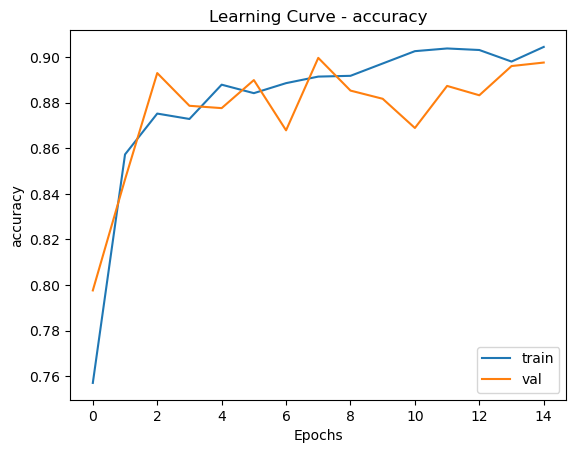

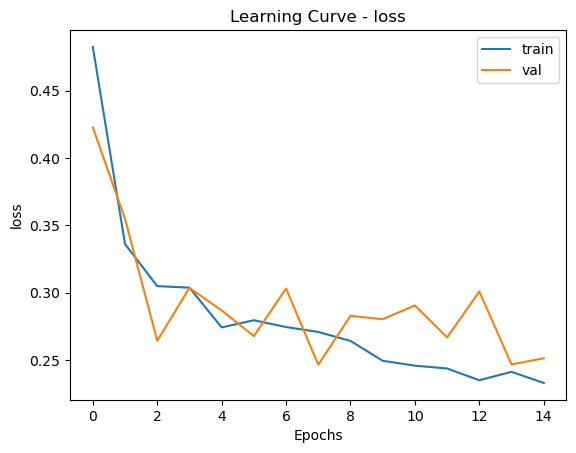

In [83]:
history_cancer = model_cancer.fit(train_gen_cancer, validation_data=val_gen_cancer, epochs=15, verbose=2)

# Save model in modern format
model_cancer.save('cancer_classifier_model.keras')

# Optional: Plot learning curve to visualise training progress
def plot_learning_curve(history, metric='accuracy'):
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f"Learning Curve - {metric}")
    plt.show()

plot_learning_curve(history_cancer, 'accuracy')
plot_learning_curve(history_cancer, 'loss')

## Step 7: CNN model for cell-type classification

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,116 (477.02 KB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 - 3s - 17ms/step - accuracy: 0.5889 - loss: 1.0244 - val_accuracy: 0.6404 - val_loss: 0.8995
Epoch 2/15
185/185 - 2s - 12ms/step - accuracy: 0.6775 - loss: 0.8455 - val_accuracy: 0.7152 - val_loss: 0.7168
Epoch 3/15
185/185 - 3s - 15ms/step - accuracy: 0.7052 - loss: 0.7653 - val_accuracy: 0.6865 - val_loss: 0.7483
Epoch 4/15
185/185 - 3s - 14ms/step - accuracy: 0.7122 - loss: 0.7548 - val_accuracy: 0.7316 - val_loss: 0.7069
Epoch 5/15
185/185 - 3s - 14ms/step - accuracy: 0.7235 - loss: 0.7249 - val_accuracy: 0.7259 - val_loss: 0.7026
Epoch 6/15
185/185 - 3s - 17ms/step - accuracy: 0.7193 - loss: 0.7379 - val_accuracy: 0.7474 - val_loss: 0.6638
Epoch 7/15
185/185 - 3s - 15ms/step - accuracy: 0.7301 - loss: 0.6981 - val_accuracy: 0.7444 - val_loss: 0.6648
Epoch 8/15
185/185 - 2s - 13ms/step - accuracy: 0.7285 - loss: 0.7091 - val_accuracy: 0.7259 - val_loss: 0.7009
Epoch 9/15
185/185 - 2s - 12ms/step - accuracy: 0.7309 - loss: 0.6985 - val_accuracy: 0.7362 - val_loss: 0.6853
Epo

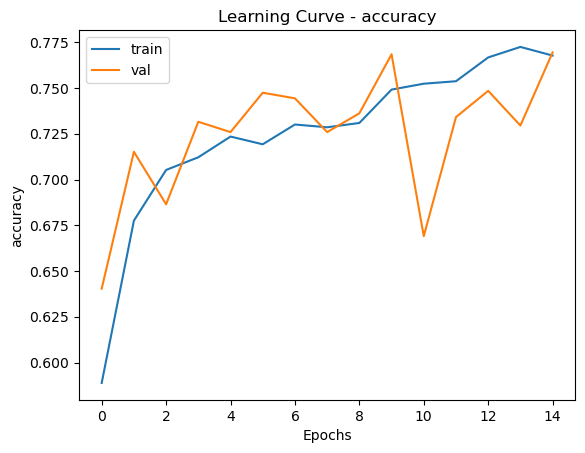

In [85]:
# Instantiate generators for cell type classification (4 classes)
train_gen_cell = CustomDataGenerator(train_data, task='cell')
val_gen_cell = CustomDataGenerator(val_data, task='cell')

# Build CNN model for 4-class classification
model_cell = Sequential([
    Input(shape=(27,27,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output classes for cell types
])

model_cell.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cell.summary()

# Step 8: Train the cell-type model
history_cell = model_cell.fit(train_gen_cell, validation_data=val_gen_cell, epochs=15, verbose=2)

# Save model
model_cell.save('celltype_classifier_model.keras')

# Step 9: Plot learning curves
plot_learning_curve(history_cell, 'accuracy')


# Step 6: Train the Model
history_cancer = model_cancer.fit(train_gen_cancer, validation_data=val_gen_cancer, epochs=15, verbose=2)

# Save model in modern format
model_cancer.save('cancer_classifier_model.keras')

# Optional: Plot learning curve to visualise training progress
def plot_learning_curve(history, metric='accuracy'):
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f"Learning Curve - {metric}")
    plt.show()

plot_learning_curve(history_cancer, 'accuracy')
plot_learning_curve(history_cancer, 'loss')

# Interpretation: If val_accuracy plateaus early or decreases while train improves -> overfitting
# If both val and train accuracy are low and improve slowly -> underfitting or insufficient capacity


# === Step 7: CNN Model for Cell-Type Classification ===
# Instantiate generators for cell type classification (4 classes)
train_gen_cell = CustomDataGenerator(train_data, task='cell')
val_gen_cell = CustomDataGenerator(val_data, task='cell')

# Build CNN model for 4-class classification
model_cell = Sequential([
    Input(shape=(27,27,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output classes for cell types
])

model_cell.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cell.summary()

# Step 8: Train the cell-type model
history_cell = model_cell.fit(train_gen_cell, validation_data=val_gen_cell, epochs=15, verbose=2)

# Save model
model_cell.save('celltype_classifier_model.keras')

# Step 9: Plot learning curves
plot_learning_curve(history_cell, 'accuracy')
plot_learning_curve(history_cell, 'loss')
